#**Klasyfikacja artykułów na kategorie: "world", "sports", "business" oraz "Science".**

Model powstał na potrzeby projektu końcowego kursu Data Science prowadzonego przez PFIG.
Celem projektu jest stworzenie i wytrenowanie modelu klasyfikującego artykuły po tytule oraz ich krótkim opisie i przypisanie ich do odpowiedniej kategorii.
Do wytrenowania modelu wykorzystany został zbiór danych "AG News Classification Dataset" dostępny na platformie [Kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset).
Do uruchomienia kodu we własnym środowisku konieczne jest posiadanie konta na platformie Kaggle oraz pobranie pliku kaggle.json z zakładki Account, który umożliwia wykorzystywanie API Kaggle do pobierania danych.

## Importy

Na początku importujemy potrzebne biblioteki, a także instalujemy bibliotekę Kaggle przy użyciu polecenia !pip install kaggle. Następnie importujemy moduły i pakiet pandas, numpy, matplotlib.pyplot, re, string, tensorflow, nltk, sklearn, gensim oraz keras potrzebne do analizy i przetwarzania danych oraz budowy modelu.

In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn import preprocessing
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, Dense, GlobalMaxPooling1D, Embedding, Activation
from sklearn.metrics import classification_report

## Wczytywanie danych

Następnie wczytujemy zbiór danych, korzystając z narzędzia Google Colab i biblioteki pandas. Pobieramy i rozpakowujemy pliki za pomocą polecenia files.upload() i kaggle.api.dataset_download_files(). Dane treningowe i testowe są wczytywane do obiektów train_data i test_data.

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mateuszoch","key":"ec4d1e2eb6e64cdf44e11895804f885d"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
import kaggle

In [9]:
kaggle.api.dataset_download_files('amananandrai/ag-news-classification-dataset', unzip=True)

In [10]:
test_data = pd.read_csv("/content/test.csv")
train_data = pd.read_csv("/content/train.csv")

## Zapoznanie ze zbiorem

Zapoznajemy się ze zbiorem, aby wiedzieć jak wygląda i co należy z nim zrobić aby móc wytrenować dobry model.

In [11]:
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [12]:
test_data.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB


## Łączenie kolumn Title i Description

Łączymy kolumny 'Title' i 'Description' dla danych treningowych i testowych, aby stworzyć nową kolumnę 'text' zawierającą pełny tekst. Usuwamy również kolumny 'Title' i 'Description', które nie będą już potrzebne.

In [15]:
train_data['text'] = train_data['Title'] + ' ' + train_data['Description']
test_data['text'] = test_data['Title'] + ' ' + test_data['Description']

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
 3   text         120000 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.7+ MB


In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
 3   text         7600 non-null   object
dtypes: int64(1), object(3)
memory usage: 237.6+ KB


In [18]:
train_data.head()

,Class Index,Title,Description,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [19]:
train_data = train_data.drop(columns=['Title', 'Description'])
test_data = test_data.drop(columns=['Title', 'Description'])

In [20]:
train_data.head()

,Class Index,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [21]:
test_data.head()

,Class Index,text
0,3,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...


## Definiowanie etykiet

Definiujemy etykiety, które będą wykorzystywane do klasyfikacji artykułów

In [22]:
labels = {1:'World News', 2:'Sports News', 3:'Business News', 4:'Science-Technology News'}

In [23]:
train_data['label'] = train_data['Class Index'].map(labels)
test_data['label'] = test_data['Class Index'].map(labels)


In [24]:
train_data = train_data.drop(columns=['Class Index'])
test_data = test_data.drop(columns=['Class Index'])

In [25]:
train_data.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,Business News
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business News
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business News
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business News
4,"Oil prices soar to all-time record, posing new...",Business News


In [26]:
train_data['text'][0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

## Czyszczenie tekstu

Przeprowadzamy proces czyszczenia tekstu, aby pozbyć się znaków specjalnych, znaczników HTML, interpunkcji, liczb, a także zmniejszyć wszystkie litery. Usuwamy również stopwords, czyli słowa o niskiej wartości semantycznej.

### Usuwanie znaków specjalnych, interpunkcji itd.

In [27]:
def clean(text):
    text = re.sub('\[.*?\]', '', text) # usuwanie znaków specjalnych
    text = re.sub('https?://\S+|www\.\S+', '', text) # usuwa wyrażenia odpowiadające adresom URL
    text = re.sub('<.*?>+', '', text) # usuwanie znaczników HTML
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # usuwanie znaków interpunkcyjnych
    text = re.sub('\n', '', text) # usuwanie znaków nowej linii
    text = re.sub('\w*\d\w*', '', text) # usuwanie whitespace oraz liczby
    text = re.sub('  ', ' ', text)
    return text

In [28]:
train_data['text'] = train_data['text'].apply(lambda x:clean(x))
test_data['text'] = test_data['text'].apply(lambda x:clean(x))

In [29]:
train_data['text'][0]

'Wall St Bears Claw Back Into the Black Reuters Reuters Shortsellers Wall Streets dwindlingband of ultracynics are seeing green again'

### Zmiana wielkości liter

In [30]:
def clean_low(text):
  lower = text.lower()
  tokens = word_tokenize(lower)
  return (' '.join(tokens)).strip()

In [31]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [32]:
train_data['text'] = train_data['text'].apply(lambda x:clean_low(x))
test_data['text'] = test_data['text'].apply(lambda x:clean_low(x))

In [33]:
train_data['text'][0]

'wall st bears claw back into the black reuters reuters shortsellers wall streets dwindlingband of ultracynics are seeing green again'

### Usuwanie stopwords

In [34]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
def clean_stop(text):
  stop_words = set(stopwords.words('english'))
  words = text.split()
  cleaned_words = [word for word in words if word.lower() not in stop_words]
  cleaned_text = ' '.join(cleaned_words)
  return cleaned_text

In [36]:
train_data['text'] = train_data['text'].apply(lambda x:clean_stop(x))
test_data['text'] = test_data['text'].apply(lambda x:clean_stop(x))

In [37]:
train_data['text'][0]

'wall st bears claw back black reuters reuters shortsellers wall streets dwindlingband ultracynics seeing green'

## Podział danych na zbiór treningowy i validacyjny

Dokonujemy podziału danych treningowych na zbiór treningowy i walidacyjny, aby móc ocenić jakość modelu. Wykorzystujemy funkcję train_test_split() z biblioteki sklearn.

In [38]:
X_train, X_validation, y_train, y_validation = train_test_split(train_data['text'], train_data['label'], test_size=0.2, random_state=123)

## Przetwarzanie tekstu

Przeprowadzamy kilka etapów przetwarzania tekstu, takich jak tokenizacja, zamiana słów na wektory przy użyciu modelu Word2Vec, konwersja słów na sekwencje liczbowe, a także kodowanie etykiet za pomocą LabelEncoder z biblioteki sklearn.

### Podział tekstu na listę słów

In [39]:
words_list = []
for i in train_data['text']:
  words_list.append(i.split())
print(words_list[:3])

[['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'shortsellers', 'wall', 'streets', 'dwindlingband', 'ultracynics', 'seeing', 'green'], ['carlyle', 'looks', 'toward', 'commercial', 'aerospace', 'reuters', 'reuters', 'private', 'investment', 'firm', 'carlyle', 'groupwhich', 'reputation', 'making', 'welltimed', 'occasionallycontroversial', 'plays', 'defense', 'industry', 'quietly', 'placedits', 'bets', 'another', 'part', 'market'], ['oil', 'economy', 'cloud', 'stocks', 'outlook', 'reuters', 'reuters', 'soaring', 'crude', 'prices', 'plus', 'worriesabout', 'economy', 'outlook', 'earnings', 'expected', 'tohang', 'stock', 'market', 'next', 'week', 'depth', 'thesummer', 'doldrums']]


### Zamiana słów na wektory

In [40]:
vec_model = Word2Vec(words_list, vector_size=60, window=5, min_count=1, workers=25)
print(vec_model)

Word2Vec<vocab=89740, vector_size=60, alpha=0.025>


### Tokenizacja słów

In [41]:
token = Tokenizer(89740)
token.fit_on_texts(train_data['text'])
token_text = token.texts_to_sequences(train_data['text'])
token_text = pad_sequences(token_text)

### Label Encoder

In [42]:
la = preprocessing.LabelEncoder()
y = la.fit_transform(train_data['label'])
y = to_categorical(y)
print(y[:10])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


## Podział na zbiór testowy i treningowy

In [43]:
X_train, X_test, y_train, y_test = train_test_split(np.array(token_text), y, test_size=0.2, random_state=123)

## Model sieci neuronowej

Budujemy model za pomocą biblioteki keras i wykorzystujemy warstwy takie jak Embedding, Conv1D, GlobalMaxPooling1D, Dropout i Dense. Kompilujemy model, określamy optymalizator, funkcję straty i metryki. Następnie uczymy model na danych treningowych.

### Model 1

In [44]:
model = Sequential()

vocab_size = 89740
embedding_dim = 120
max_length = len(X_train[0])
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

filters = 256
kernel_size = 10 
model.add(Conv1D(filters, kernel_size, activation='relu'))

model.add(GlobalMaxPooling1D())

dropout_rate = 0.2
model.add(Dropout(dropout_rate))

num_classes = len(la.classes_)
model.add(Dense(num_classes, activation='softmax'))

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(X_train, y_train, batch_size=256, epochs=5, validation_data=(X_train, y_train))

Epoch 1/5
375/375 [==============================] - 62s 139ms/step - loss: 0.3910 - accuracy: 0.8758 - val_loss: 0.1445 - val_accuracy: 0.9550
Epoch 2/5
375/375 [==============================] - 22s 57ms/step - loss: 0.1555 - accuracy: 0.9489 - val_loss: 0.0745 - val_accuracy: 0.9780
Epoch 3/5
375/375 [==============================] - 13s 36ms/step - loss: 0.0860 - accuracy: 0.9714 - val_loss: 0.0390 - val_accuracy: 0.9890
Epoch 4/5
375/375 [==============================] - 12s 32ms/step - loss: 0.0473 - accuracy: 0.9849 - val_loss: 0.0208 - val_accuracy: 0.9948
Epoch 5/5
375/375 [==============================] - 9s 24ms/step - loss: 0.0265 - accuracy: 0.9923 - val_loss: 0.0126 - val_accuracy: 0.9968


In [47]:
loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)

750/750 [==============================] - 3s 3ms/step - loss: 0.4227 - accuracy: 0.8996
Loss: 0.4227278530597687
Accuracy: 0.8995833396911621


### Model 2

In [48]:
model = Sequential()

vocab_size = 89740
embedding_dim = 60
max_length = len(X_train[0])
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

filters = 128
kernel_size = 5 
model.add(Conv1D(filters, kernel_size, activation='relu'))

model.add(GlobalMaxPooling1D())

dropout_rate = 0.2
model.add(Dropout(dropout_rate))

num_classes = len(la.classes_)
model.add(Dense(num_classes, activation='softmax'))

In [49]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history = model.fit(X_train, y_train, batch_size=256, epochs=5, validation_data=(X_train, y_train))

Epoch 1/5
375/375 [==============================] - 47s 121ms/step - loss: 0.4836 - accuracy: 0.8508 - val_loss: 0.1789 - val_accuracy: 0.9448
Epoch 2/5
375/375 [==============================] - 14s 38ms/step - loss: 0.1875 - accuracy: 0.9395 - val_loss: 0.1005 - val_accuracy: 0.9709
Epoch 3/5
375/375 [==============================] - 10s 25ms/step - loss: 0.1145 - accuracy: 0.9628 - val_loss: 0.0556 - val_accuracy: 0.9847
Epoch 4/5
375/375 [==============================] - 6s 16ms/step - loss: 0.0698 - accuracy: 0.9776 - val_loss: 0.0334 - val_accuracy: 0.9910
Epoch 5/5
375/375 [==============================] - 5s 14ms/step - loss: 0.0451 - accuracy: 0.9858 - val_loss: 0.0211 - val_accuracy: 0.9943


In [51]:
loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)

750/750 [==============================] - 2s 2ms/step - loss: 0.3778 - accuracy: 0.9026
Loss: 0.37784838676452637
Accuracy: 0.9026250243186951


## Krzywa uczenia

Rysujemy wykresy przedstawiające stratę i dokładność treningu i walidacji w zależności od epok.

In [46]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

In [47]:
epochs = range(1, len(train_loss) + 1)

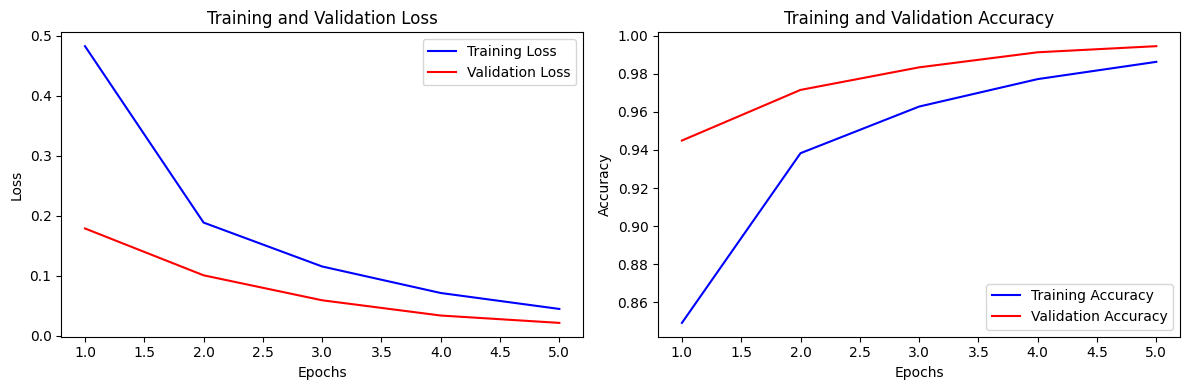

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Wykres krzywej ROC i AUC

Obliczamy i rysujemy krzywą ROC i obliczamy AUC dla każdej klasy.

In [49]:
from sklearn.metrics import roc_curve, auc

In [50]:
y_pred = model.predict(X_test)

750/750 [==============================] - 1s 2ms/step


In [51]:
y_test_encoded = np.argmax(y_test, axis=1)

In [52]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [53]:
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

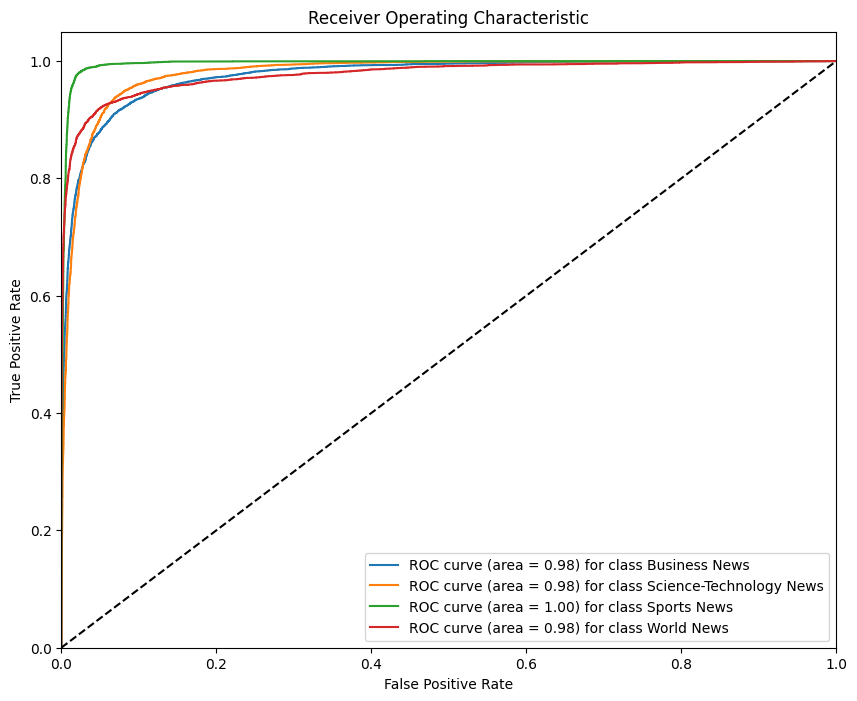

In [54]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], la.classes_[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [55]:
for i in range(num_classes):
    print('AUC for class %s: %.2f' % (la.classes_[i], roc_auc[i]))

AUC for class Business News: 0.98
AUC for class Science-Technology News: 0.98
AUC for class Sports News: 1.00
AUC for class World News: 0.98


## Confusion matrix

Obliczamy macierz pomyłek i przedstawiamy ją w postaci wykresu.

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [57]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

750/750 [==============================] - 1s 2ms/step


In [58]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

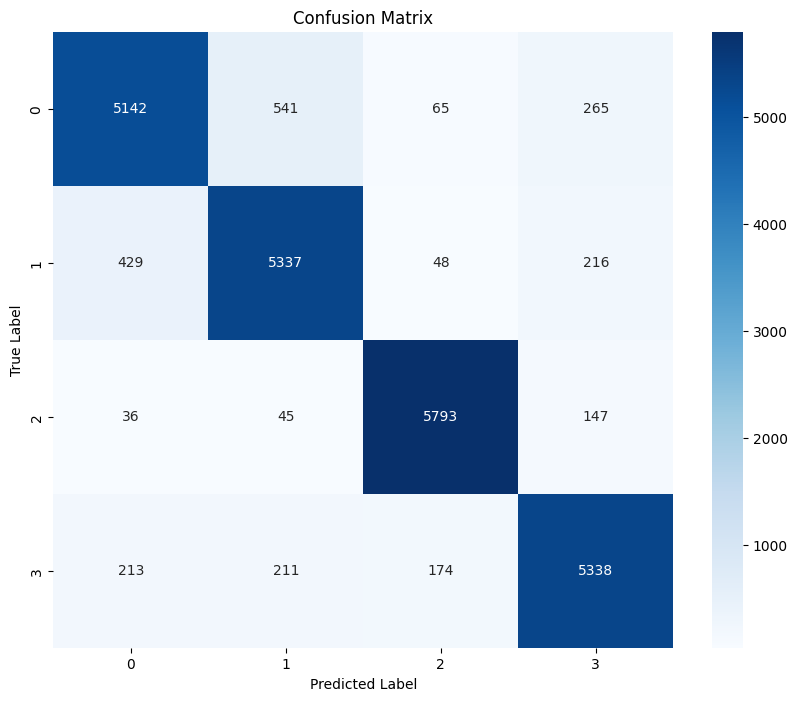

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Podsumowanie
Dzięki bardzo dobremu zbalansowaniu danych w zbiorze, zastosowanie prostych metod przetwarzania danych umożliwiło utworzenie modelu sieci sekwencyjnej osiągającej wynik Accuracy na poziomie około 90%.
Należy jednak, że ten wynik oznacza również, że w 10% przypadków model może się mylić. Jednak moim zdaniem jest to całkowicie akceptowalny wynik.